In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
import csv
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import math

In [2]:
data= pd.read_csv("/Users/mariagiustiniano/Desktop/Machine Learning /cal-housing.csv")

## Pre-processing Data 

In [3]:
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

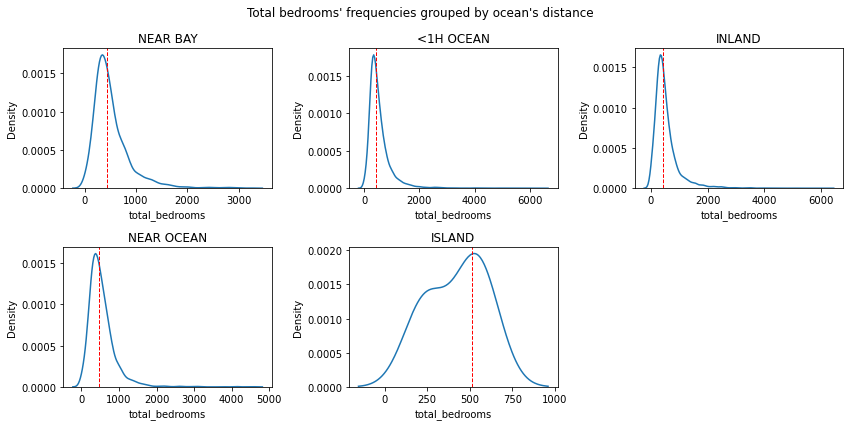

In [64]:
plt.figure(figsize=(12, 6))
plt.suptitle("Total bedrooms' frequencies grouped by ocean's distance ")

for j in range(1,6):
    plt.subplot(2,3,j)
    plt.title(data.ocean_proximity.unique()[j-1])
    sns.kdeplot(data=data, x=data.loc[:,'total_bedrooms'][data.ocean_proximity==data.ocean_proximity.unique()[j-1]])
    median= data.loc[:,'total_bedrooms'][data.ocean_proximity==data.ocean_proximity.unique()[j-1]].quantile(0.5)
    plt.axvline(median, linestyle='dashed', linewidth=1, color= 'red')
    
plt.tight_layout();

In [3]:
data.replace(['ISLAND','NEAR OCEAN','NEAR BAY','<1H OCEAN', 'INLAND'],[1,2,3,5,6], inplace=True)

for i in data.ocean_proximity.unique():
    data.loc[data.ocean_proximity==i]=data.loc[data.ocean_proximity==i].fillna(data.loc[data.ocean_proximity==i,"total_bedrooms"].quantile(0.5))

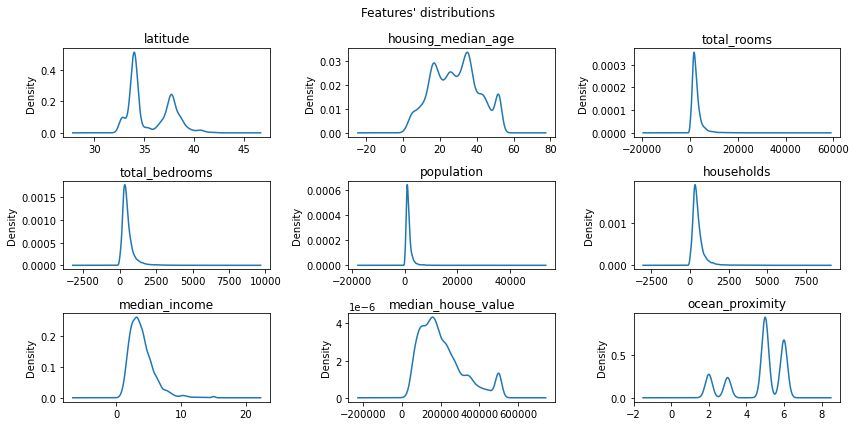

In [35]:
plt.figure(figsize=(12, 6))
plt.suptitle("Features' distributions")

for j in range(1,10):
    plt.subplot(3,3,j)
    plt.title(data.iloc[:,j].name)
    data.iloc[:,j].plot.density()

plt.tight_layout();

## Ridge regression

/Users/mariagiustiniano/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


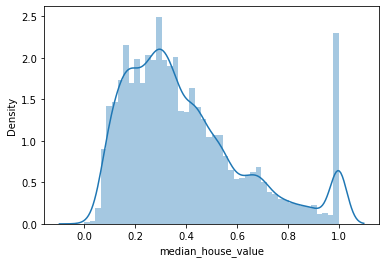

In [4]:
from sklearn.model_selection import train_test_split, learning_curve

data= (data-data.min())/(data.max()-data.min())

S = data.drop('median_house_value', axis=1)
Y = data.loc[:, "median_house_value"] 

sns.distplot(Y);

In [5]:
from sklearn.base import BaseEstimator

def mse (Y,Y_hat):
    MSE = sum((Y-Y_hat)**2)/Y.shape[0]
    return MSE

class ridge(BaseEstimator):
    def __init__(self, alpha= 1.00):
        self.alpha = alpha
        
    def fit(self, S, Y):
        I = np.identity(S.shape[1])
        self.w = LA.inv( self.alpha * I + S.T@S) @ (S.T@Y)
        return self.w
    
    def predict(self, S):
        Y_hat = S @ self.w
        return Y_hat

    def score(self, S, Y):
        Y_pred = self.predict(S)
        return mse(Y, Y_pred)   

    def R2 (self, Y, S):
        SS_res = ((Y-self.predict(S))**2).sum(axis=0)
        SS_tot= ((Y-np.mean(Y))**2).sum(axis=0)
        R_2 = 1 - ( SS_res/SS_tot )
        return R_2

## Threefold split 

In [6]:
S_train, S_test ,Y_train , Y_test = train_test_split(S, Y, random_state= 42, train_size = 0.7)
S_train_t,S_dev,Y_train_t,Y_dev= train_test_split(S_train, Y_train, random_state= 42, train_size = 0.75)   
    
alpha = np.linspace(0, 1, 50)
losses = {}

for a in alpha:
    
    model = ridge( alpha = a )
    w = model.fit(S_train_t,Y_train_t)
    
    y_hat_dev = model.predict(S_dev)    
    y_hat_train= model.predict(S_train)
    y_hat_test= model.predict(S_test)
    
    loss_dev= mse(Y_dev, y_hat_dev)
    loss_train= mse(y_hat_train,Y_train)
    loss_test = mse(Y_test, y_hat_test)
    
    r2_train= model.R2(Y_train,S_train)
    r2_test= model.R2(Y_test, S_test)
    
    losses[a] = [loss_train, loss_test, loss_dev, r2_train, r2_test]
    

mse_alpha = pd.DataFrame.from_dict(losses, orient='index', columns=['mse_train','mse_test','mse_dev','r2_train','r2_test']).reset_index().rename(columns={'index': 'alpha'})

In [7]:
print("Best alpha:",mse_alpha.loc[mse_alpha.mse_dev==mse_alpha.mse_dev.min(), 'alpha'].values[0])
print("MSE on train set:",mse_alpha.loc[mse_alpha.mse_dev==mse_alpha.mse_dev.min(), 'mse_train'].values[0])
print("MSE on test set:",mse_alpha.loc[mse_alpha.mse_dev==mse_alpha.mse_dev.min(), 'mse_test'].values[0])
print("R squared on the Train set:",mse_alpha.loc[mse_alpha.mse_dev==mse_alpha.mse_dev.min(), 'r2_train'].values[0])
print("R squared on the Test set:",mse_alpha.loc[mse_alpha.mse_dev==mse_alpha.mse_dev.min(), 'r2_test'].values[0])

Best alpha: 1.0
MSE on train set: 0.023112246626737616
MSE on test set: 0.022801830398737656
R squared on the Train set: 0.5942175171947703
R squared on the Test set: 0.5912917252847574


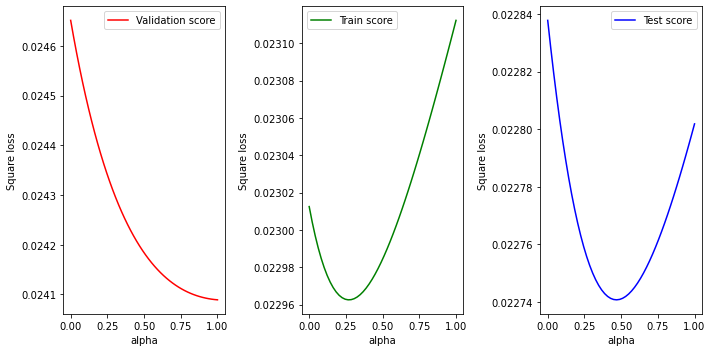

In [8]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.plot(alpha, mse_alpha.mse_dev, color="r",
         label="Validation score")
plt.legend()
plt.xlabel('alpha')
plt.ylabel('Square loss')

plt.subplot(1,3,2)
plt.plot(alpha, mse_alpha.mse_train, color="g",
         label="Train score")
plt.legend()
plt.xlabel('alpha')
plt.ylabel('Square loss')

plt.subplot(1,3,3)
plt.plot(alpha, mse_alpha.mse_test, color="b",
         label="Test score")
plt.legend()
plt.xlabel('alpha')
plt.ylabel('Square loss')


plt.tight_layout();

## Cross_validation 

In [16]:
from sklearn.utils import shuffle
from itertools import combinations


class cv(BaseEstimator):
    def __init__(self, k):
        self.k = k
        
    def fold_k(self,df,y):
    
        df = shuffle(df)
        m= df.shape[0]
        k = self.k
        self.folds ={}
        self.Y_folds={}
        for i in range(1,k+1):
            self.folds[i] = df.iloc[(i*(m//k)-(m//k)):(i*m//k)]
        for s in range(1,k+1):
            self.Y_folds[s]= y.iloc[self.folds[s].index.values]
    
        comb = list(combinations(list(range(1,k+1)),k-1))
        self.Train={}
    
        for j in range(k):
            features=[]
            target=[]
            for k in comb[j]:
                features.append(self.folds[k])
                target.append(self.Y_folds[k])
            
            self.Train[j]= [pd.concat(features), pd.concat(target)]
        
        self.Test={}
    
        for t in range(k):
            x= list(set(list(range(1,k+1))).difference(set(comb[t])))
            self.Test[t]= [self.folds[x[0]], self.Y_folds[x[0]]]
    
        return self.folds, self.Train, self.Test
    
    def cross_validation(self, alpha):
        train_score =[]
        test_score =[]
        for i in range(self.k):
            Mod = ridge(alpha = alpha)
            W= Mod.fit(self.Train[i][0],self.Train[i][1])
            train_score.append(Mod.score(self.Train[i][0],self.Train[i][1]))
            test_score.append(Mod.score(self.Test[i][0],self.Test[i][1]))
        return pd.DataFrame({'train_score': train_score, 'test_score': test_score})

In [17]:
CV=cv(5)
folds,tr,te= CV.fold_k(S,Y)
cross_val_results= {}
for a in alpha :
    cross_val_results[a]= CV.cross_validation(a)
    
results={}

for a in alpha:
    results[a] = [cross_val_results[a].test_score.mean(),cross_val_results[a].test_score.std(),
                  cross_val_results[a].train_score.mean(),cross_val_results[a].train_score.std()]


results= pd.DataFrame.from_dict(results, orient='index', 
                                columns=['test_mean','test_std','train_mean', 'train_std']).reset_index().rename(columns={'index':'alpha'})

In [18]:
print("Best alpha:" ,results.loc[results.train_mean==results.train_mean.min(),'alpha'].values[0])
print("Train score:", results.loc[results.train_mean==results.train_mean.min(),'train_mean'].values[0])
print("CV risk estimate:", results.loc[results.train_mean==results.train_mean.min(),'test_mean'].values[0])

Best alpha: 0.0
Train score: 0.02282662938687023
CV risk estimate: 0.022936838422932076


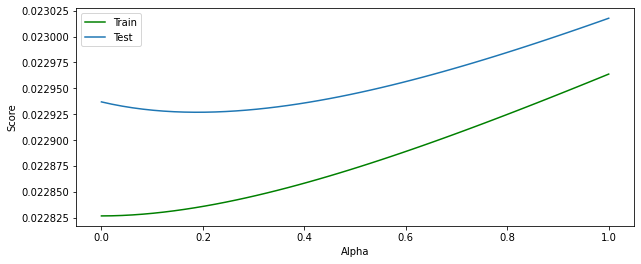

In [19]:
plt.figure(figsize=(10,4))
plt.plot(alpha, results.loc[:, 'train_mean'], label='Train', color='g')
plt.plot(alpha, results.loc[:, 'test_mean'], label='Test' )
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend();

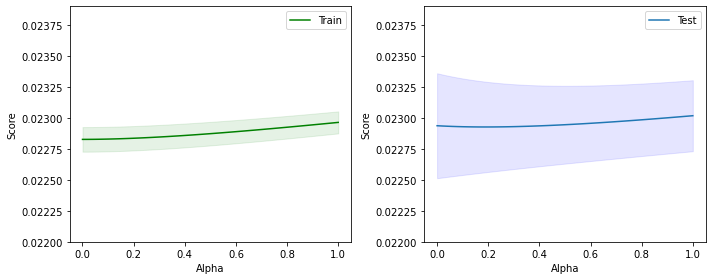

In [20]:
plt.figure (figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(alpha, results.loc[:, 'train_mean'],label='Train', color='g' )
plt.fill_between(alpha, results.train_mean - results.train_std,
                 results.train_mean + results.train_std, alpha=0.1, color="g")
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend()
plt.ylim(0.022,0.0239)

plt.subplot(1,2,2)
plt.plot(alpha, results.loc[:, 'test_mean'],label='Test' )
plt.fill_between(alpha, results.test_mean - results.test_std,
                 results.test_mean + results.test_std, alpha=0.1,color="b")
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend()
plt.ylim(0.022,0.0239)
plt.tight_layout();

### Results on the entire dataset

In [21]:
best_alpha= alpha[0]
Mod= ridge(alpha=best_alpha)
w_tot=Mod.fit(S,Y)
Y_hat= Mod.predict(S)
mse_tot= Mod.score(S,Y)
R2= Mod.R2(Y,S)

In [22]:
print("MSE on the entire dataset:",mse_tot)
print("R squared on the entire dataset:",R2)

MSE on the entire dataset: 0.02283704751736542
R squared on the entire dataset: 0.5965688411541219


## PCA

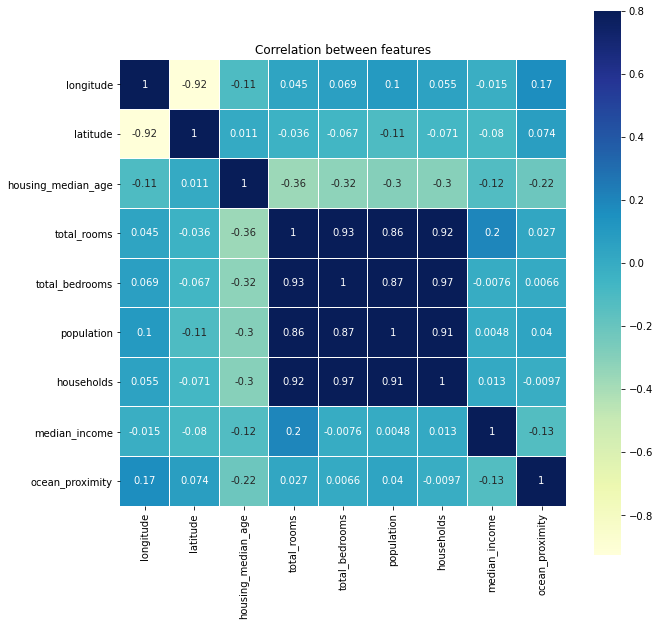

In [23]:
corr = S.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.01,square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

#plt.savefig("corrmap")

In [24]:
cov= np.cov(S.T)
eig_vals, eig_vecs = np.linalg.eig(cov)

tot_eig_vals= sum(eig_vals)
var_explained = [(i / tot_eig_vals)*100 for i in sorted(eig_vals, reverse=True)]

U, X, Vt = np.linalg.svd((S-S.mean()), full_matrices=False)

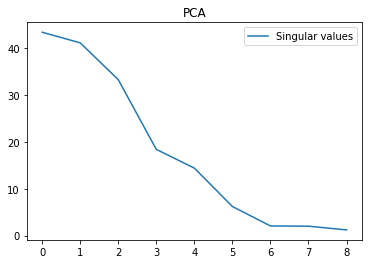

<Figure size 432x288 with 0 Axes>

In [25]:
plt.title('PCA')
plt.plot(X, label='Singular values');
plt.legend();
plt.show();

plt.savefig("singvalues")

Explained variance taking five components: 99.08030802546011


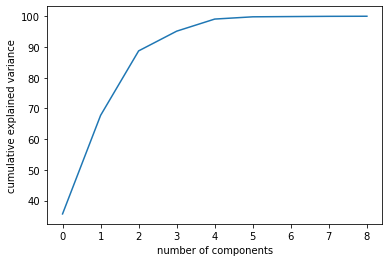

In [26]:
plt.plot(np.cumsum(var_explained))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
print('Explained variance taking five components:', sum(var_explained[0:5]))

In [27]:
S_pca = (eig_vecs.T[:5] @ (S-S.mean()).T).T

In [28]:
Y_pca = (Y-Y.mean())

In [29]:
S_train, S_test ,Y_train , Y_test = train_test_split(S_pca, Y_pca, random_state= 42, train_size = 0.7)
S_train_t,S_dev,Y_train_t,Y_dev= train_test_split(S_train, Y_train, random_state= 42, train_size = 0.75)   
    
alpha = np.linspace(0, 1, 50)
losses_pca = {}

for a in alpha:
    
    model_pca = ridge( alpha = a )
    w = model_pca.fit(S_train_t,Y_train_t)
    
    y_hat_dev = model_pca.predict (S_dev)
    y_hat_train= model_pca.predict (S_train)
    y_hat_test= model_pca.predict (S_test)
    
    loss_dev = mse(Y_dev,y_hat_dev)
    loss_train= mse(Y_train,y_hat_train)
    loss_test = mse(Y_test, y_hat_test)
    
    r2_train= model_pca.R2( Y_train, S_train)
    r2_test= model_pca.R2( Y_test, S_test )
    
    losses_pca[a] = [loss_train, loss_test, loss_dev, r2_train, r2_test]
    

mse_alpha_pca = pd.DataFrame.from_dict(losses_pca, orient='index', columns=['mse_train','mse_test','mse_dev','r2_train','r2_test']).reset_index().rename(columns={'index': 'alpha'})

In [30]:
print("Best alpha:",mse_alpha_pca.loc[mse_alpha_pca.mse_dev==mse_alpha_pca.mse_dev.min(), 'alpha'].values[0])
print("MSE on train set:",mse_alpha_pca.loc[mse_alpha_pca.mse_dev==mse_alpha_pca.mse_dev.min(), 'mse_train'].values[0])
print("MSE on test set:",mse_alpha_pca.loc[mse_alpha_pca.mse_dev==mse_alpha_pca.mse_dev.min(), 'mse_test'].values[0])
print("R squared on the Train set:",mse_alpha_pca.loc[mse_alpha_pca.mse_dev==mse_alpha_pca.mse_dev.min(), 'r2_train'].values[0])
print("R squared on the Test set:",mse_alpha_pca.loc[mse_alpha_pca.mse_dev==mse_alpha_pca.mse_dev.min(), 'r2_test'].values[0])

Best alpha: 1.0
MSE on train set: 0.02410181573674267
MSE on test set: 0.023496859957695918
R squared on the Train set: 0.5768436194145075
R squared on the Test set: 0.5788337634917583


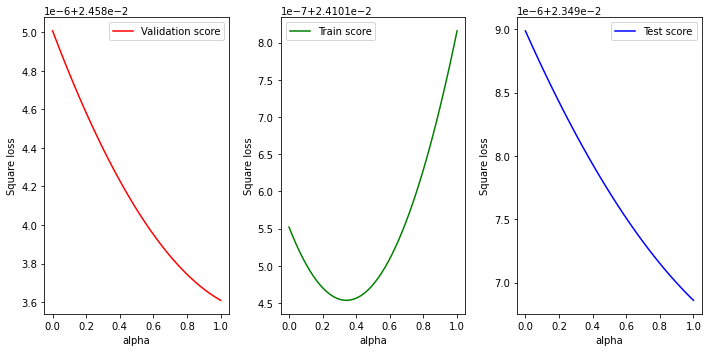

In [31]:
plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.plot(alpha, mse_alpha_pca.mse_dev, color="r",
         label="Validation score")
plt.legend()
plt.xlabel('alpha')
plt.ylabel('Square loss')

plt.subplot(1,3,2)
plt.plot(alpha, mse_alpha_pca.mse_train, color="g",
         label="Train score")
plt.legend()
plt.xlabel('alpha')
plt.ylabel('Square loss')

plt.subplot(1,3,3)
plt.plot(alpha, mse_alpha_pca.mse_test, color="b",
         label="Test score")
plt.legend()
plt.xlabel('alpha')
plt.ylabel('Square loss')


plt.tight_layout();

## Cross-Validation after PCA 

In [32]:
CV=cv(5)
folds,tr,te= CV.fold_k(S_pca,Y_pca)

cross_val_results_pca= {}

for a in alpha :
    cross_val_results_pca[a]= CV.cross_validation(a)
    
results_pca={}

for a in alpha:
    results_pca[a] = [cross_val_results_pca[a].test_score.mean(), cross_val_results_pca[a].test_score.std(),
                      cross_val_results_pca[a].train_score.mean(), cross_val_results_pca[a].train_score.std()]


results_pca= pd.DataFrame.from_dict(results_pca, orient='index', 
                                columns=['test_mean','test_std','train_mean', 'train_std']).reset_index().rename(columns={'index':'alpha'})

In [33]:
print("Best alpha:" ,results_pca.loc[results_pca.train_mean==results_pca.train_mean.min(),'alpha'].values[0])
print("Train score:", results_pca.loc[results_pca.train_mean==results_pca.train_mean.min(),'train_mean'].values[0])
print("CV risk estimate:", results_pca.loc[results_pca.train_mean==results_pca.train_mean.min(),'test_mean'].values[0])

Best alpha: 0.0
Train score: 0.02391623669037179
CV risk estimate: 0.02393022521738179


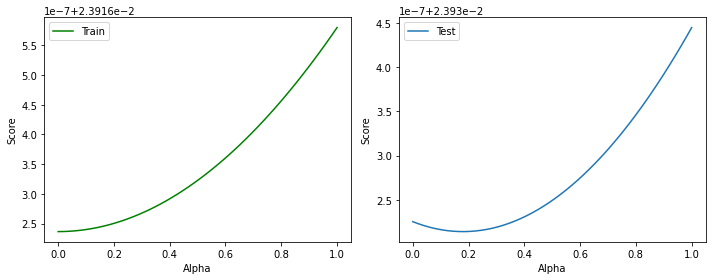

In [34]:
plt.figure (figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(alpha, results_pca.loc[:, 'train_mean'], label='Train', color='g' )
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend()


plt.subplot(1,2,2)
plt.plot(alpha, results_pca.loc[:, 'test_mean'], label='Test' )
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend()

plt.tight_layout();

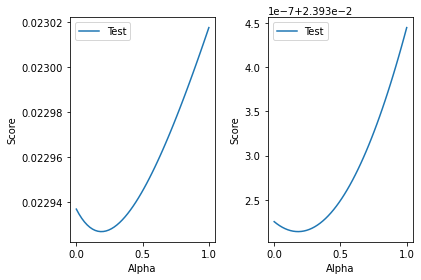

In [38]:
plt.subplot(1,2,1)
plt.plot(alpha, results.loc[:, 'test_mean'], label='Test' )
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend()

plt.subplot(1,2,2)
plt.plot(alpha, results_pca.loc[:, 'test_mean'], label='Test' )
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend()

plt.tight_layout();

### Results on the whole dataset after PCA

In [46]:
best_alpha= alpha[0]
Mod= ridge(alpha=best_alpha)
w_tot=Mod.fit(S_pca,Y_pca)
Y_hat= Mod.predict(S_pca)
mse_tot= Mod.score(S_pca,Y_pca)
R2= Mod.R2(Y_pca,S_pca)

In [47]:
print("MSE on the entire dataset:",mse_tot)
print("R squared on the entire dataset:",R2)

(0.023917637952508546, 0.5774795148672578)